# Model fitting for MetMCC-SCAN
## Yanrong (Jerry) Ji

## TODO:
- build a pipeline for preprocessing
>- further group some levels and compare
>- missing val: imputation/leave as it is
>- more feature engineering?
- bayesian optimization (done)
- merge SEER data
- bagged XGBoost

## Major issues:
- Categorical + Numeric
- Missing values
- Imbalance

In [ ]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install scikit-optimize
# !pip install imblearn

In [1]:
# general modules
import os
from copy import deepcopy
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import accuracy_score,confusion_matrix, auc, roc_auc_score
from sklearn.metrics import roc_curve, f1_score, average_precision_score
from sklearn.metrics import precision_score, recall_score

# xgboost,lightgbm,catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Bayesian optimization
from skopt import BayesSearchCV
from skopt import callbacks
from skopt.space import Real, Integer

# Class imbalance
from imblearn.over_sampling import SMOTENC
from imblearn.ensemble import BalancedRandomForestClassifier

# set seaborn style
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
sns.set(font_scale=1.5)

In [2]:
BASE_DIR = os.path.dirname(os.path.realpath('model_fitting')) + '/'

In [3]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_clean.pkl')

In [4]:
mcc_ncdb.head()

,DEPTH,TUMOR_SIZE,PRIMARY_SITE,AGE,SEX,GROWTH_PATTERN,HISTOLOGY,LATERALITY,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,TUMOR_BASE_TRANSFECTION,SLNB,YEAR_SINCE_DIAGNOSIS
3,999.0,999,C441,82,1,999,8140,2,9,999,999,999,0.0,5
8,999.0,1,C444,71,1,999,8247,0,0,999,999,999,0.0,5
9,999.0,20,C441,49,2,999,8480,2,9,999,999,999,0.0,3
14,1.0,2,C443,43,1,999,8247,2,9,0,0,20,0.0,2
19,50.0,25,C447,59,2,999,8247,1,0,999,999,999,0.0,2


## Split data

In [5]:
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE','LYMPH_VASCULAR_INVASION',
                        'TUMOR_SIZE', 'DEPTH', 'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 'SLNB'
                       ]]
mcc_ncdb_sel = pd.get_dummies(mcc_ncdb_sel)
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [6]:
# all features
mcc_ncdb = pd.get_dummies(mcc_ncdb)
X = np.array(mcc_ncdb.loc[:, mcc_ncdb.columns != 'SLNB'])
y = np.array(mcc_ncdb.loc[:, mcc_ncdb.columns == 'SLNB'])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.1, 
                                                    random_state = 123) # set seed to ensure reproducibility

In [7]:
X_train.shape

(6048, 75)

In [8]:
X_train_sel.shape

(6048, 32)

In [9]:
mcc_ncdb.columns

Index(['DEPTH', 'TUMOR_SIZE', 'AGE', 'SEX', 'SLNB', 'YEAR_SINCE_DIAGNOSIS',
       'PRIMARY_SITE_C440', 'PRIMARY_SITE_C441', 'PRIMARY_SITE_C442',
       'PRIMARY_SITE_C443', 'PRIMARY_SITE_C444', 'PRIMARY_SITE_C445',
       'PRIMARY_SITE_C446', 'PRIMARY_SITE_C447', 'PRIMARY_SITE_C448',
       'PRIMARY_SITE_C449', 'GROWTH_PATTERN_1.0', 'GROWTH_PATTERN_20.0',
       'GROWTH_PATTERN_999.0', 'HISTOLOGY_8140', 'HISTOLOGY_8143',
       'HISTOLOGY_8147', 'HISTOLOGY_8200', 'HISTOLOGY_8240', 'HISTOLOGY_8246',
       'HISTOLOGY_8247', 'HISTOLOGY_8260', 'HISTOLOGY_8310', 'HISTOLOGY_8323',
       'HISTOLOGY_8347', 'HISTOLOGY_8390', 'HISTOLOGY_8400', 'HISTOLOGY_8401',
       'HISTOLOGY_8402', 'HISTOLOGY_8407', 'HISTOLOGY_8409', 'HISTOLOGY_8410',
       'HISTOLOGY_8413', 'HISTOLOGY_8430', 'HISTOLOGY_8480', 'HISTOLOGY_8481',
       'HISTOLOGY_8490', 'HISTOLOGY_8500', 'HISTOLOGY_8573', 'HISTOLOGY_8832',
       'HISTOLOGY_8833', 'HISTOLOGY_8891', 'HISTOLOGY_9120', 'LATERALITY_0',
       'LATERALITY_1', 

In [10]:
mcc_ncdb_sel.columns

Index(['AGE', 'SEX', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'PRIMARY_SITE_C440',
       'PRIMARY_SITE_C441', 'PRIMARY_SITE_C442', 'PRIMARY_SITE_C443',
       'PRIMARY_SITE_C444', 'PRIMARY_SITE_C445', 'PRIMARY_SITE_C446',
       'PRIMARY_SITE_C447', 'PRIMARY_SITE_C448', 'PRIMARY_SITE_C449',
       'LYMPH_VASCULAR_INVASION_0.0', 'LYMPH_VASCULAR_INVASION_1.0',
       'LYMPH_VASCULAR_INVASION_8.0', 'LYMPH_VASCULAR_INVASION_9.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_0.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_1.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_20.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_30.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_999.0', 'IMMUNE_SUPPRESSION_0.0',
       'IMMUNE_SUPPRESSION_1.0', 'IMMUNE_SUPPRESSION_20.0',
       'IMMUNE_SUPPRESSION_30.0', 'IMMUNE_SUPPRESSION_40.0',
       'IMMUNE_SUPPRESSION_50.0', 'IMMUNE_SUPPRESSION_60.0',
       'IMMUNE_SUPPRESSION_70.0', 'IMMUNE_SUPPRESSION_999.0'],
      dtype='object')

## Balance dataset by SMOTE

In [11]:
cat_features_idx = list(range(4,74,1))
cat_features_idx.append(3)
sm = SMOTENC(random_state=123, categorical_features = cat_features_idx) # set seed to ensure reproducibility
X_train_balanced, y_train_balanced = sm.fit_sample(X_train, y_train.ravel())

cat_features_idx_sel = list(range(5,31,1))
cat_features_idx_sel.append(1)
sm_sel = SMOTENC(random_state=123, categorical_features = cat_features_idx_sel) 
X_train_sel_balanced, y_train_sel_balanced = sm_sel.fit_sample(X_train_sel, y_train_sel.ravel())

In [12]:
X_train_balanced.shape

(10494, 75)

In [13]:
X_train_sel_balanced.shape

(10494, 32)

In [31]:
def negative_pred_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    return TN/(TN+FN)

## Baseline: logistic regression (selected vars, not binned)

In [32]:
log_clf_sel = LogisticRegression(penalty='none', max_iter=10000)
log_clf_sel.fit(X_train_sel_balanced,y_train_sel_balanced.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

[[527  74]
 [ 51  21]]
test accuracy: 0.8142644873699851
test NPV: 0.9117647058823529
test Precision: 0.22105263157894736
test Recall: 0.2916666666666667
test AUC: 0.7141107413569976
test F1: 0.251497005988024
test AUPR: 0.20422642744811098


## logistic regression (all vars, not binned)

In [33]:
log_clf = LogisticRegression(penalty='none', max_iter=10000)
log_clf.fit(X_train_balanced,y_train_balanced.ravel())
y_prob = np.asarray(log_clf.predict_proba(X_test))
y_pred = np.asarray(log_clf.predict(X_test))
y_test = np.asarray(y_test)
print(confusion_matrix(y_test, y_pred))
print("test accuracy: %s" % log_clf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

[[466 135]
 [ 33  39]]
test accuracy: 0.75037147102526
test NPV: 0.9338677354709419
test Precision: 0.22413793103448276
test Recall: 0.5416666666666666
test AUC: 0.6898225180255131
test F1: 0.3170731707317073
test AUPR: 0.20015532598976626


## Random forest (selected vars, not binned)

In [34]:
# train a random forest classifier
rf_sel = RandomForestClassifier(oob_score=True, 
                                 random_state=123) # set seed to ensure reproducibility
rf_sel.fit(X_train_sel_balanced,y_train_sel_balanced.ravel())
y_prob_sel = np.asarray(rf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % rf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.8231797919762258
test NPV: 0.8950819672131147
test Precision: 0.12698412698412698
test Recall: 0.1111111111111111
test AUC: 0.6111804400073951
test F1: 0.11851851851851852
test AUPR: 0.13667237539548904


## Random forest (all vars, not binned)

In [35]:
# train a random forest classifier
rf = RandomForestClassifier(oob_score=True, 
                                 random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_balanced,y_train_balanced.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.8306092124814265
test NPV: 0.9051580698835274
test Precision: 0.20833333333333334
test Recall: 0.20833333333333334
test AUC: 0.6627842484747642
test F1: 0.20833333333333334
test AUPR: 0.17954013958163836


## Random forest (cost-sensitive, all vars, not binned)

In [37]:
# train a random forest classifier
rf = RandomForestClassifier(oob_score=True, 
                            class_weight={0:1,1:1.121e13},
                            random_state=42) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.7890044576523031
test NPV: 0.9135135135135135
test Precision: 0.2033898305084746
test Recall: 0.3333333333333333
test AUC: 0.660877703826955
test F1: 0.2526315789473684
test AUPR: 0.1649256411839471


## Balanced Random Forest

In [43]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.6419019316493314
test NPV: 0.9368932038834952
test Precision: 0.17624521072796934
test Recall: 0.6388888888888888
test AUC: 0.6944791088925865
test F1: 0.27627627627627627
test AUPR: 0.2063799588235088


## Bayesian optimization: RF (all vars, not binned)

In [46]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (5, 100),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1, 75),
                       }, 
                        n_iter = 20, verbose = 5, n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.95:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train, y_train.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob = np.asarray(opt_rf.predict_proba(X_test))
y_pred = np.asarray(opt_rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % opt_rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.615244708994709
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   15.2s remaining:   22.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   15.3s finished


best score: 0.6228505291005291
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.6228505291005291
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.5s finished


best score: 0.6228505291005291
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    7.2s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.6228505291005291
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.9s remaining:    5.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    4.0s finished


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   13.9s remaining:   20.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   14.0s finished


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.1s finished


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   11.0s remaining:   16.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   11.2s finished


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.2s finished


best score: 0.6246693121693122
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished


best score: 0.6335978835978836
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   23.0s remaining:   34.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   23.2s finished


best score: 0.6335978835978836
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.8s finished


best score: 0.6335978835978836
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    4.2s finished


best score: 0.6651785714285714
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   10.9s remaining:   16.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   11.0s finished


best score: 0.6651785714285714
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.6s finished


best score: 0.6651785714285714
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   15.7s remaining:   23.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   15.9s finished


best score: 0.6651785714285714
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    3.5s finished


best score: 0.6651785714285714
best parameter set: OrderedDict([('criterion', 'entropy'), ('max_depth', 5), ('max_features', 12), ('n_estimators', 677)])
val. score: 0.6651785714285714
test accuracy: 0.6760772659732541
test NPV: 0.9382151029748284
test Precision: 0.1906779661016949
test Recall: 0.625
test AUC: 0.7023941578850065
test F1: 0.2922077922077922
test AUPR: 0.20623990892095453


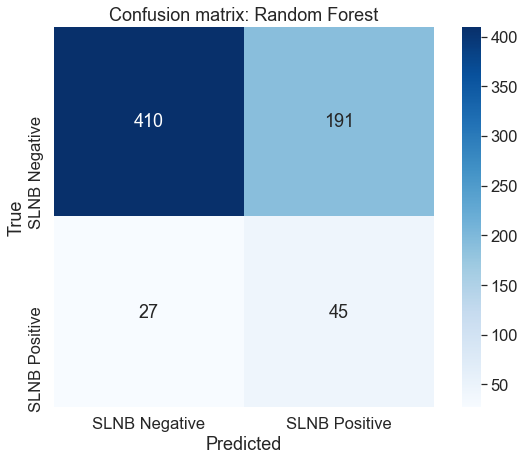

In [47]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()